In [1]:
from IPython.core.display import HTML
import requests
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import datetime
import seaborn as sns
from dateutil import parser
import pytz
import pylab as pl
from pyquery import PyQuery as pq
import numpy as np
import scipy
import pandas as pd
from lxml import etree
import os
from os import path
from pprint import pprint
import dateutil
import json
%matplotlib inline

In [2]:
all_motions_json = []
for i in range(1, 637+1):
    try:
        j = json.load(open('jsons/%s.json' % i))
        all_motions_json.append(j)
    except:
        pass

In [3]:
j['fecha']

'01/07/2016'

In [4]:
s_votes = []

for m in all_motions_json:
    v = m['votos']
    s = pd.DataFrame(v)
    s['sesion_id'] = m['sesion_id']
    s['datestr'] = m['fecha']
    s = s.set_index(['legislador_id', 'sesion_id'])
    s_votes.append(s)

In [5]:
df_votes = pd.concat(s_votes)

In [6]:
def vote_to_number(v):
    MAPPING = {
        'AFIRMATIVO': 1, # Yes
        'AUSENTE': 0, # Absent, did not come to the session
        'NEGATIVO': -1, # No
        'ABSTENCION': 0, # person is present, but not vote
    }
    return MAPPING.get(v, 0)
    
df_votes['vote-value'] = df_votes['voto'].apply(vote_to_number)

In [7]:
from datetime import date

df_votes['date'] = df_votes['datestr'].apply(lambda x: date(
        int(x.split('/')[2]), 
        int(x.split('/')[1]), 
        int(x.split('/')[0])
    ))
df_votes['datetime'] = df_votes['date'].apply(lambda d: datetime.datetime(*d.timetuple()[:7]))

In [8]:
#df_votes['date']
#10/12/2013 - 10/12/2015

In [9]:
s = df_votes['partido'].value_counts()
df_party_counts = pd.DataFrame(df_votes['partido'].value_counts()).reset_index()
df_party_counts.columns = ['party', 'count']
df_party_counts.to_csv('data/party-count.csv')

In [49]:
#df_votes

In [45]:
print('Total number of sessions:')
print(len(df_votes.reset_index()['sesion_id'].value_counts()))

Total number of sessions:
371


In [50]:
print('Total number of legislators:')
print(len(df_votes.reset_index()['legislador_id'].value_counts()))

Total number of legislators:
648


In [10]:
len(df_votes)

93330

In [11]:
df_votes.to_csv('data/votes.csv')

In [12]:
df_member_profile = df_votes.reset_index()[['legislador_id', 'agrupacion', 'agrupacion_color', 'camara', 'mail', 'nombre', 'partido']].drop_duplicates()
print(len(df_member_profile))
df_member_profile = df_member_profile.drop_duplicates('legislador_id')
print(len(df_member_profile))
df_member_profile.to_csv('data/member-profile.csv')

1131
648


In [13]:
df_member_profile[
    df_member_profile['legislador_id'] == 738
]

,legislador_id,agrupacion,agrupacion_color,camara,mail,nombre,partido
48160,738,Massismo y aliados,#b185b7,diputados,mtundis@diputados.gob.ar,"TUNDIS, MIRTA",FRENTE RENOVADOR


In [14]:
df_member_profile.set_index('legislador_id').ix[738]

agrupacion                Massismo y aliados
agrupacion_color                     #b185b7
camara                             diputados
mail                mtundis@diputados.gob.ar
nombre                        TUNDIS,  MIRTA
partido                     FRENTE RENOVADOR
Name: 738, dtype: object

In [15]:
df_selected_votes = df_votes[
    (df_votes['date'] >= date(2013, 12, 12))
    &
    (df_votes['date'] <= date(2015, 12, 12))
]

In [16]:
len(df_selected_votes)

37379

In [17]:
df_votes_brief = df_selected_votes[['voto', 'vote-value']]

In [18]:
df_votes_brief['voto'].value_counts()

AFIRMATIVO    25638
AUSENTE        7516
NEGATIVO       3241
ABSTENCION      984
Name: voto, dtype: int64

In [19]:
df_matrix = df_votes_brief.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')

In [20]:
df_matrix = df_matrix.fillna(0)

In [21]:
df_matrix.to_csv('data/matrix-2013-2015.csv')

In [42]:
df_matrix.shape

(264, 146)

In [22]:
X = np.matrix(df_matrix.fillna(0).as_matrix()).astype('int8')

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)
df_pc = pd.DataFrame(X_reduced, index=df_matrix.index, columns=['PC1', 'PC2', 'PC3'])

In [24]:
pca.explained_variance_

array([ 28.22993681,   3.62389691,   1.95130054])

Watch out:
* The explained variance by PC1 to PC3 is very small in this data set
* The data set is highly non-linear

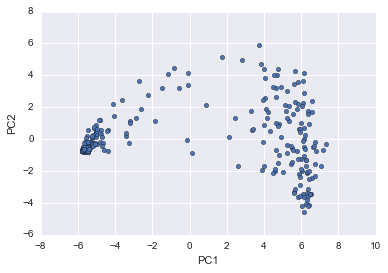

In [25]:
%matplotlib inline
df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [26]:
df_party_count_color = pd.read_csv('data/party-count-color.csv')

In [27]:
len(df_pc)

264

In [28]:
len(df_member_profile)

648

In [29]:
df_pc_member = pd.merge(df_pc.reset_index(), df_member_profile, how='left',
                        left_on='legislador_id', right_on='legislador_id')

In [30]:
len(df_pc_member)

264

In [31]:
len(df_pc)

264

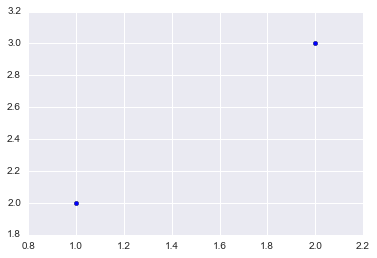

In [32]:
plt.scatter(1, 2)
plt.scatter(2, 3)

('', '')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#007caf')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('UNEN - FAP - UCR', '#8eab35')


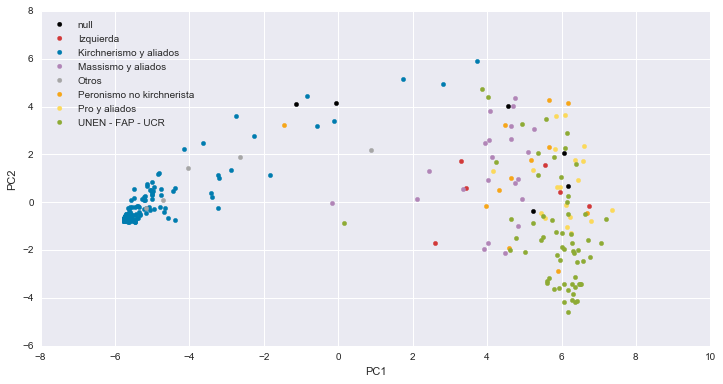

In [33]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

('', '')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#007caf')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('UNEN - FAP - UCR', '#8eab35')


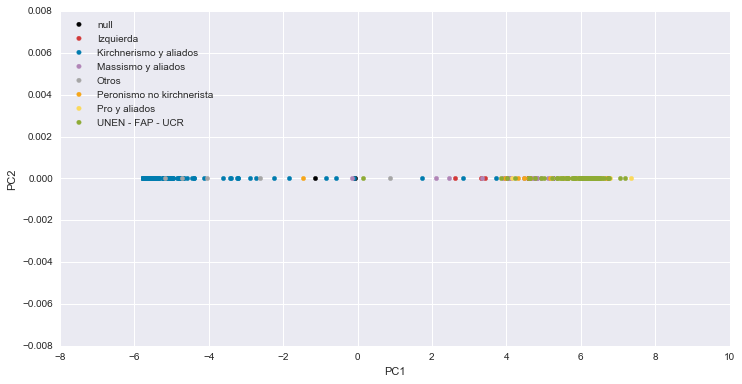

In [34]:
%matplotlib inline

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], [0] * len(group['PC1']), color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [35]:
df_pc_member['legislador_id'] = df_pc_member['legislador_id'].apply(lambda x: str(x))
open('data/pc-member-3d.json', 'w').write(json.dumps(
    df_pc_member.set_index('legislador_id').T.to_dict()
    ))
open('data/pc-member-3d.js', 'w').write(json.dumps(
    df_pc_member.set_index('legislador_id').T.to_dict()
    ))

78026

In [36]:
df_pc_member

,legislador_id,PC1,PC2,PC3,agrupacion,agrupacion_color,camara,mail,nombre,partido
0,1,-0.581584,3.205870,-0.160135,Kirchnerismo y aliados,#007caf,diputados,nabdaladem@diputados.gob.ar,"Abdala de Matarazzo, Norma Amanda",FRENTE CÍVICO POR SANTIAGO
1,8,5.984325,1.039177,-1.520055,UNEN - FAP - UCR,#8eab35,diputados,oaguad@diputados.gob.ar,"Aguad, Oscar Raúl",UNIÓN CÍVICA RADICAL
2,10,3.960056,-0.156964,0.767200,Peronismo no kirchnerista,#f6a619,diputados,laguilar@diputados.gob.ar,"AGUILAR, Lino Walter",FRENTE PERONISTA
3,19,5.452833,-1.578642,-0.600426,UNEN - FAP - UCR,#8eab35,diputados,ralfonsin@diputados.gob.ar,"ALFONSÍN, Ricardo Luis",UNIÓN CÍVICA RADICAL
4,22,6.595750,2.366079,2.555453,Pro y aliados,#fbd95b,diputados,lalonso@diputados.gob.ar,"ALONSO, Laura",PRO
5,23,-5.770926,-0.774505,0.212649,Kirchnerismo y aliados,#007caf,diputados,malonso@diputados.gob.ar,"ALONSO, María Luz",FRENTE PARA LA VICTORIA
6,38,4.636692,-0.676913,-1.173376,UNEN - FAP - UCR,#8eab35,diputados,aargumedo@diputados.gob.ar,"ARGUMEDO, Alcira Susana",PROYECTO SUR
7,40,-4.400734,-0.719819,0.666265,Kirchnerismo y aliados,#007caf,diputados,aarregui@diputados.gob.ar,"ARREGUI, Andrés Roberto",FRENTE PARA LA VICTORIA
8,45,4.639838,3.211533,-0.393616,Massismo y aliados,#b185b7,diputados,aasseff@diputados.gob.ar,"ASSEFF, Alberto Emilio",FRENTE PERONISTA
9,48,-5.480399,-0.799735,-0.190062,Kirchnerismo y aliados,#007caf,diputados,havoscan@diputados.gob.ar,"AVOSCÁN, Herman",FRENTE PARA LA VICTORIA


('', '')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#007caf')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('UNEN - FAP - UCR', '#8eab35')


8

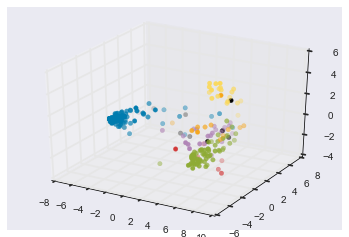

In [37]:
%matplotlib inline

x = np.array(X_reduced.T[0, :]).astype('float')
y = np.array(X_reduced.T[1, :]).astype('float')
z = np.array(X_reduced.T[2, :]).astype('float')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], group['PC3'], color=gname[1], label=gname[0])
#ax.scatter(x, y, z, picker=True, s=100)

def onpick(X_3D, event):
    #print(event)
    if hasattr(onpick, '_label'):
        #pass
        onpick._label.remove()
    thisline = event.artist
    ind = event.ind
    #print(type(ind))
    #print(X_3D[0, ind])
    names = df_matrix.iloc[ind].index.values
    #print(names)
    label = ('\n'.join(names))
    pos = (X_3D[0, ind[0]], X_3D[1, ind[0]], X_3D[2, ind[0]])
    #onpick._label = ax.set_title(label
    onpick._label = ax.text(*pos, s=label)
    fig.canvas.draw()
    
fig.canvas.mpl_connect('pick_event', lambda e: onpick(X_reduced.T, e))